In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.patches import Rectangle

In [2]:
def plot_variable_with_shapefiles(
    data, lon, lat, title, units, ax=None,
    cmap="RdBu_r", levels=21, shapefiles=None,
    extent=[65, 85, 1, 20], add_colorbar=True
):
    """
    Plots an ERA5 variable with shapefile overlay on a given axis (ax).

    Parameters:
        data : 2D numpy array
        lon, lat : 1D or 2D longitude/latitude arrays
        title : str
        units : str
        ax : matplotlib Axes (with Cartopy) — required for subplots
        cmap : str or Colormap
        levels : int or list of contour levels
        shapefiles : list of GeoDataFrames
        extent : [lon_min, lon_max, lat_min, lat_max]
        add_colorbar : bool (to control per-subplot or global colorbar)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    cf = ax.contourf(
        lon, lat, data,
        levels=levels,
        cmap=cmap,
        extend='both',
        transform=ccrs.PlateCarree()
    )

    if shapefiles:
        for shp in shapefiles:
            shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(title, fontsize=16)

    # Gridlines and ticks
    gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}
    gl.xlocator = plt.FixedLocator(np.arange(extent[0], extent[1]+1, 5))
    gl.ylocator = plt.FixedLocator(np.arange(extent[2], extent[3]+1, 5))

    if add_colorbar:
        cbar = plt.colorbar(cf, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
        cbar.set_label(units)

    return cf  # so you can add a shared colorbar if needed


In [3]:
# Load shapefiles
wg = gpd.read_file("/Users/subin/Downloads/Shape_files/wg_bnd/wg_bnd.shp")  # Western Ghats or region boundary
world = gpd.read_file("/Users/subin/Downloads/Shape_files/world_boundaries/World_Countries_shp.shp")

# Ensure shapefiles are in WGS84
wg = wg.to_crs("EPSG:4326")
world = world.to_crs("EPSG:4326")

# Define bounding box: (minx, miny, maxx, maxy) = (lon_min, lat_min, lon_max, lat_max)
bbox = (65, 0, 85, 20)

# Clip using GeoDataFrame's .cx spatial indexer
world_clipped = world.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

In [4]:

# ======= CONFIGURATION =======
event_file = "GPM_3IMERGDF_07_precipitation.20240730-20240730.nc"
clim_file = "GPM_3IMERGM_07_precipitation.19980101-20241231.MONTH.nc"

# Optional shapefiles (set to None if not available)
wg_shp = gpd.read_file("/Users/subin/Downloads/Shape_files/wg_bnd/wg_bnd.shp")  # Western Ghats or region boundary
world_shp = gpd.read_file("/Users/subin/Downloads/Shape_files/world_boundaries/World_Countries_shp.shp")
# Plotting extent
extent = [65, 85, 0, 20]

# ======= LOAD DATA =======
ds_event = xr.open_dataset(event_file)
ds_event = ds_event.sel(lat = slice(0.75,20),lon =slice(65,85))
ds_clim = xr.open_dataset(clim_file)
ds_clim = ds_clim.sel(lat = slice(0.75,20),lon =slice(65,85))
var_event = list(ds_event.data_vars)[0]
var_clim = list(ds_clim.data_vars)[0]

ctt_event = ds_event[var_event].values
ctt_clim = ds_clim[var_clim].values
ctt_anom = ctt_event - ctt_clim

lat = ds_event['lat'].values
lon = ds_event['lon'].values
lon2d, lat2d = np.meshgrid(lon, lat)

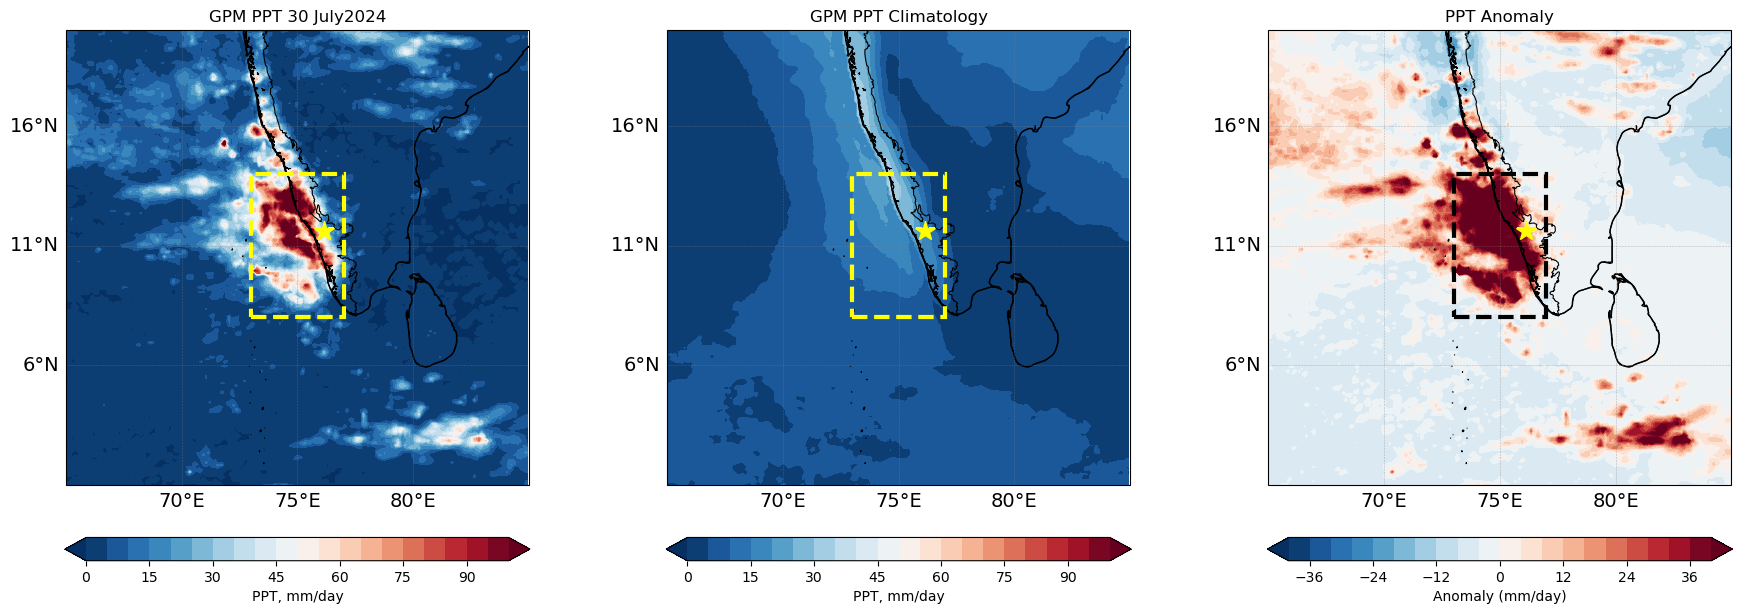

In [5]:
# Coordinates for bounding box and Wayanad
bbox_coords = {
    'lon_min': 73,
    'lon_max': 77,
    'lat_min': 8,
    'lat_max': 14
}
wayanad_coords = {
    'lon': 76.13,   # Approx. longitude of Wayanad
    'lat': 11.61    # Approx. latitude of Wayanad
}

fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(ctt_event, lon, lat, "GPM PPT 30 July2024", "mm", ax=axs[0],
                                    levels=np.linspace(0, 100, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
bbox = Rectangle(
    (bbox_coords['lon_min'], bbox_coords['lat_min']),
    width=bbox_coords['lon_max'] - bbox_coords['lon_min'],
    height=bbox_coords['lat_max'] - bbox_coords['lat_min'],
    edgecolor='yellow',
    facecolor='none',
    linewidth=3,
    linestyle='--',
    zorder=10
)
axs[0].add_patch(bbox)
# Add star marker at Wayanad
axs[0].plot(
    wayanad_coords['lon'], wayanad_coords['lat'],
    marker='*', color='yellow', markersize=15,
    markeredgecolor='yellow', zorder=11,
    label='Wayanad'
)
cf2 = plot_variable_with_shapefiles(ctt_clim, lon, lat, "GPM PPT Climatology", "mm", ax=axs[1],
                                    levels=np.linspace(0,100, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
bbox = Rectangle(
    (bbox_coords['lon_min'], bbox_coords['lat_min']),
    width=bbox_coords['lon_max'] - bbox_coords['lon_min'],
    height=bbox_coords['lat_max'] - bbox_coords['lat_min'],
    edgecolor='yellow',
    facecolor='none',
    linewidth=3,
    linestyle='--',
    zorder=10
)
axs[1].add_patch(bbox)
# Add star marker at Wayanad
axs[1].plot(
    wayanad_coords['lon'], wayanad_coords['lat'],
    marker='*', color='yellow', markersize=15,
    markeredgecolor='yellow', zorder=11,
    label='Wayanad'
)
cf3 = plot_variable_with_shapefiles(ctt_anom, lon, lat, "PPT Anomaly", "mm/day", ax=axs[2],
                                    levels=np.linspace(-40, 40, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
bbox = Rectangle(
    (bbox_coords['lon_min'], bbox_coords['lat_min']),
    width=bbox_coords['lon_max'] - bbox_coords['lon_min'],
    height=bbox_coords['lat_max'] - bbox_coords['lat_min'],
    edgecolor='black',
    facecolor='none',
    linewidth=3,
    linestyle='--',
    zorder=10
)
axs[2].add_patch(bbox)
# Add star marker at Wayanad
axs[2].plot(
    wayanad_coords['lon'], wayanad_coords['lat'],
    marker='*', color='yellow', markersize=15,
    markeredgecolor='yellow', zorder=11,
    label='Wayanad'
)
# Colorbars
fig.colorbar(cf1, ax=axs[0], orientation="horizontal", shrink=0.8, pad=0.05).set_label("PPT, mm/day")
fig.colorbar(cf1, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("PPT, mm/day")
fig.colorbar(cf3, ax=axs[2], orientation="horizontal", shrink=0.8, pad=0.05).set_label("Anomaly (mm/day)")
#plt.savefig("GPM precipitation_30July2024.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
ds_gpm = xr.DataArray(ctt_event, dims=("latitude", "longitude"), coords={"latitude": lat,"longitude": lon})
ds_gpm_m = xr.DataArray(ctt_clim, dims=("latitude", "longitude"), coords={"latitude": lat,"longitude": lon})
gmp_zonal_avg = ds_gpm.sel(latitude=slice(8, 13), longitude = slice(73,77)).mean()
gmp_m_zonal_avg = ds_gpm_m.sel(latitude=slice(8, 13), longitude = slice(73,77)).mean()
data = {'Parameter': ['Rainfall'],
        'event': [gmp_zonal_avg.values],
       'clim' : [gmp_m_zonal_avg.values]}
df = pd.DataFrame(data)
print(df)

NameError: name 'lat' is not defined

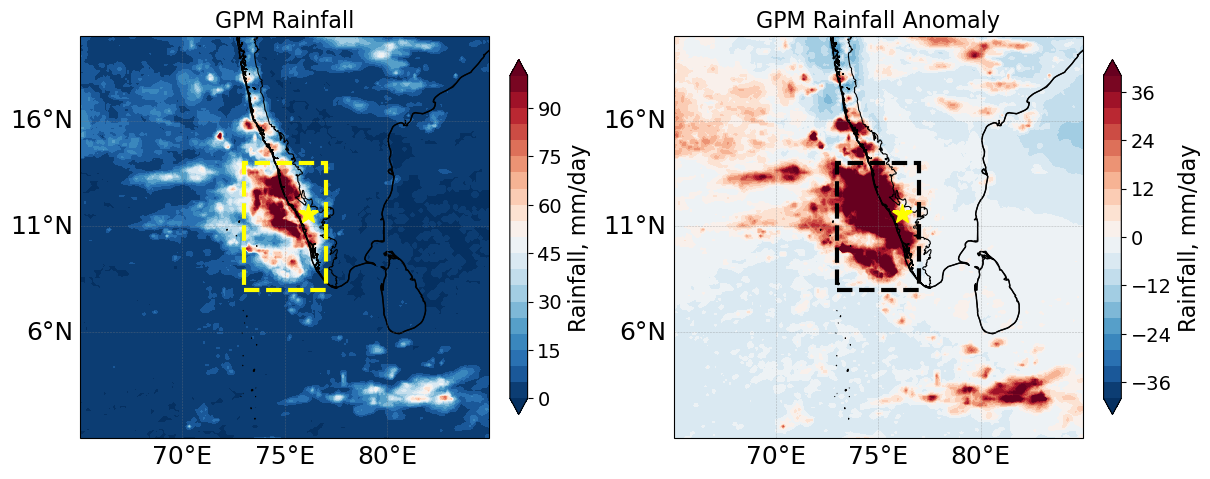

In [5]:
# Coordinates for bounding box and Wayanad
bbox_coords = {
    'lon_min': 73,
    'lon_max': 77,
    'lat_min': 8,
    'lat_max': 14
}
wayanad_coords = {
    'lon': 76.13,   # Approx. longitude of Wayanad
    'lat': 11.61    # Approx. latitude of Wayanad
}

fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

cf1 = plot_variable_with_shapefiles(ctt_event, lon, lat, "GPM Rainfall", "mm/day", ax=axs[0],
                                    levels=np.linspace(0, 100, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
bbox = Rectangle(
    (bbox_coords['lon_min'], bbox_coords['lat_min']),
    width=bbox_coords['lon_max'] - bbox_coords['lon_min'],
    height=bbox_coords['lat_max'] - bbox_coords['lat_min'],
    edgecolor='yellow',
    facecolor='none',
    linewidth=3,
    linestyle='--',
    zorder=10
)
axs[0].add_patch(bbox)
# Add star marker at Wayanad
axs[0].plot(
    wayanad_coords['lon'], wayanad_coords['lat'],
    marker='*', color='yellow', markersize=15,
    markeredgecolor='yellow', zorder=11,
    label='Wayanad'
)

cf2 = plot_variable_with_shapefiles(ctt_anom, lon, lat, "GPM Rainfall Anomaly", "mm/day", ax=axs[1],
                                    levels=np.linspace(-40, 40, 21), shapefiles=[world_clipped, wg], add_colorbar=False)
bbox = Rectangle(
    (bbox_coords['lon_min'], bbox_coords['lat_min']),
    width=bbox_coords['lon_max'] - bbox_coords['lon_min'],
    height=bbox_coords['lat_max'] - bbox_coords['lat_min'],
    edgecolor='black',
    facecolor='none',
    linewidth=3,
    linestyle='--',
    zorder=10
)
axs[1].add_patch(bbox)
# Add star marker at Wayanad
axs[1].plot(
    wayanad_coords['lon'], wayanad_coords['lat'],
    marker='*', color='yellow', markersize=15,
    markeredgecolor='yellow', zorder=11,
    label='Wayanad'
)
# Colorbars
cbar1 = fig.colorbar(cf1, ax=axs[0], orientation="vertical", shrink=0.6, pad=0.05)
cbar1.set_label("Rainfall, mm/day", fontsize=16)
cbar1.ax.tick_params(labelsize=14)
#fig.colorbar(cf2, ax=axs[1], orientation="horizontal", shrink=0.8, pad=0.05).set_label("PPT, mm/day")
cbar2 = fig.colorbar(cf2, ax=axs[1], orientation="vertical", shrink=0.6, pad=0.05)
cbar2.set_label("Rainfall, mm/day", fontsize=16)
cbar2.ax.tick_params(labelsize=14)
plt.savefig("GPM precipitation_30July2024_new.png", dpi=300, bbox_inches='tight')
plt.show()